In [58]:
import numpy as np
import pandas as pd
from numpy.random import randn
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import imp
import align_utils
import pf_utils
imp.reload(align_utils)
imp.reload(pf_utils)

from align_utils import *
from pf_utils import *

import random
import particle_filter
imp.reload(particle_filter)
from particle_filter import *
import pandas as pd
from tqdm import tqdm

In [59]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Data Loading

The data variables are:

```
gt: [timestamp, x, y]
inertial: [timestamp, sigma_dx, sigma_dy, dx, dy]
wifi: {timestamp: [x, y, sigma, distance]}
```

In [68]:
seq = 15
inertial = np.loadtxt('seq_'+str(seq)+'.txt')  # [287, 5] [t,ux,uy,x,y]
wifi = pd.read_pickle("seq_"+str(seq)+"_t10.pickle")
gt = np.load("gt_"+str(seq)+".npy")

inertial_ts = inertial[:, 0]
wifi_ts = [float(i)/10 for i in wifi.keys()]
wifi_keys = list(wifi.keys())
gt_ts = gt[:, 0]

In [69]:
0.4 * meter2pix

11.3385888

(array([46.,  1.,  1.,  4.,  3.,  7., 26., 80., 76., 20.]),
 array([1.46985070e-03, 1.66436893e-01, 3.31403935e-01, 4.96370977e-01,
        6.61338019e-01, 8.26305061e-01, 9.91272104e-01, 1.15623915e+00,
        1.32120619e+00, 1.48617323e+00, 1.65114027e+00]),
 <BarContainer object of 10 artists>)

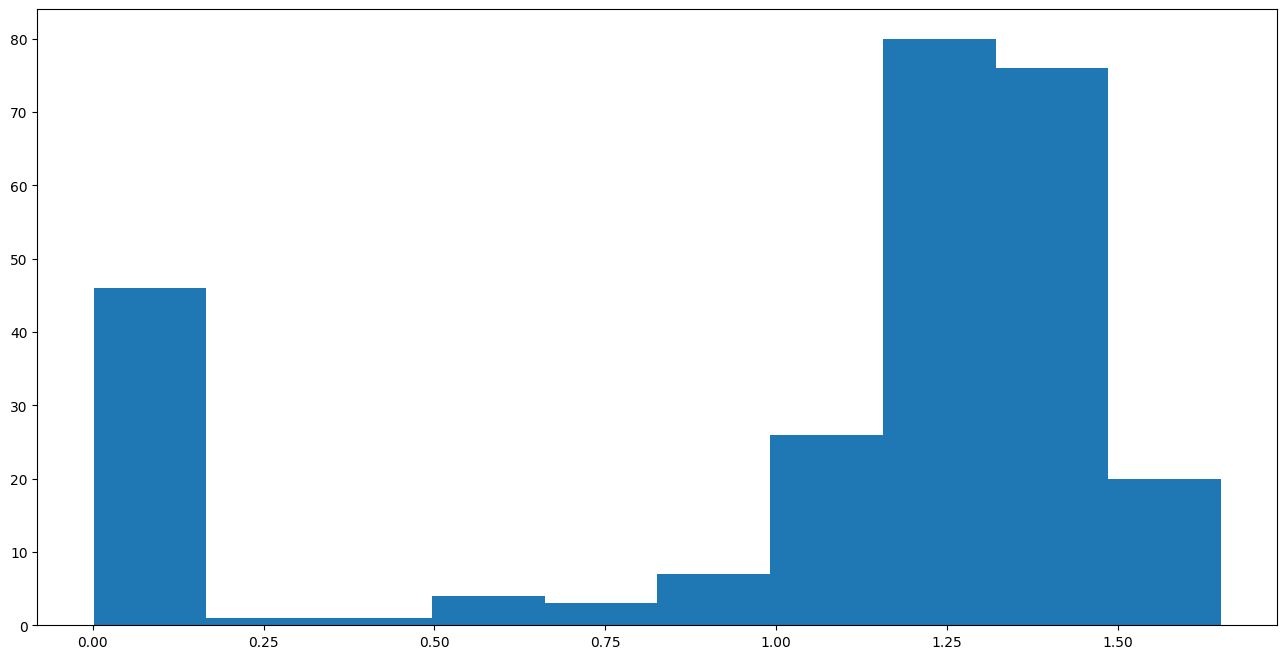

In [70]:
plt.hist(np.linalg.norm(inertial[:, 3:], axis=1))

In [71]:
meter2pix = 39.3701 * 72 / 100

In [83]:
pf_online = np.load('./23_online.npy')  # [286, 3]
pf_cloud = np.load('./23_cloud.npy')  # [286, 1000, 3]
pf_gt = np.load('./23_gt.npy')  # [286, 2]
pf_ts = np.load('./23_ts.npy')  # [286, ]
pf_error = np.linalg.norm(pf_online[:, :2] - pf_gt, axis=1)
img = plt.imread("BF3.png")

In [84]:
np.average(np.linalg.norm(pf_online[:, :2] - pf_gt, axis=1))

4.3672333114914865

In [73]:
wifi[wifi_keys[0]]

array([[ 41.15671926, -22.5543119 ,   0.43436402,  13.10816383],
       [ 29.95263029, -30.60563095,   0.5082373 ,  13.4623909 ],
       [ 36.194248  , -26.8860282 ,   0.5227688 ,  13.48823643],
       [ 28.18937183, -21.3291173 ,   0.54079586,  13.62488937],
       [ 27.52871594, -22.07398766,   0.60152775,  13.91772556],
       [ 33.1577174 , -29.87593885,   0.60722405,  13.91839123],
       [ 35.64629438, -33.40970231,   0.6169284 ,  13.95756149],
       [ 31.68750231, -31.18403628,   0.63430363,  14.05748558],
       [ 36.01918966, -33.04920776,   0.64639533,  14.08731079],
       [ 35.44529726, -18.33319496,   0.67124104,  14.22641373]])

In [74]:
wifi_ts = [float(i)/10 for i in wifi.keys()]
wifi_ts.append(1e10)

wifi_online = []
wifi_idx_now = 0
wifi_ts_next = wifi_ts[wifi_idx_now+1]
wifi_pos_now = wifi[wifi_keys[wifi_idx_now]]
for ts in pf_ts:
    if ts >= wifi_ts_next:
        wifi_idx_now+=1
        wifi_ts_next = wifi_ts[wifi_idx_now+1]
        wifi_pos_now = wifi[wifi_keys[wifi_idx_now]]
        wifi_online.append(wifi_pos_now)
    else:
        wifi_online.append(wifi_pos_now)
wifi_online = np.array(wifi_online)

# Visualization

These questions needs to be answered in visualization:

1. How does the online positioning error change over time?
2. How fast does online pf converge?
3. What is affecting the online positioning error?
4. How does WiFi positioning error affect online positioning error?
5. Does out-of-building radiomap affect online positioning error?

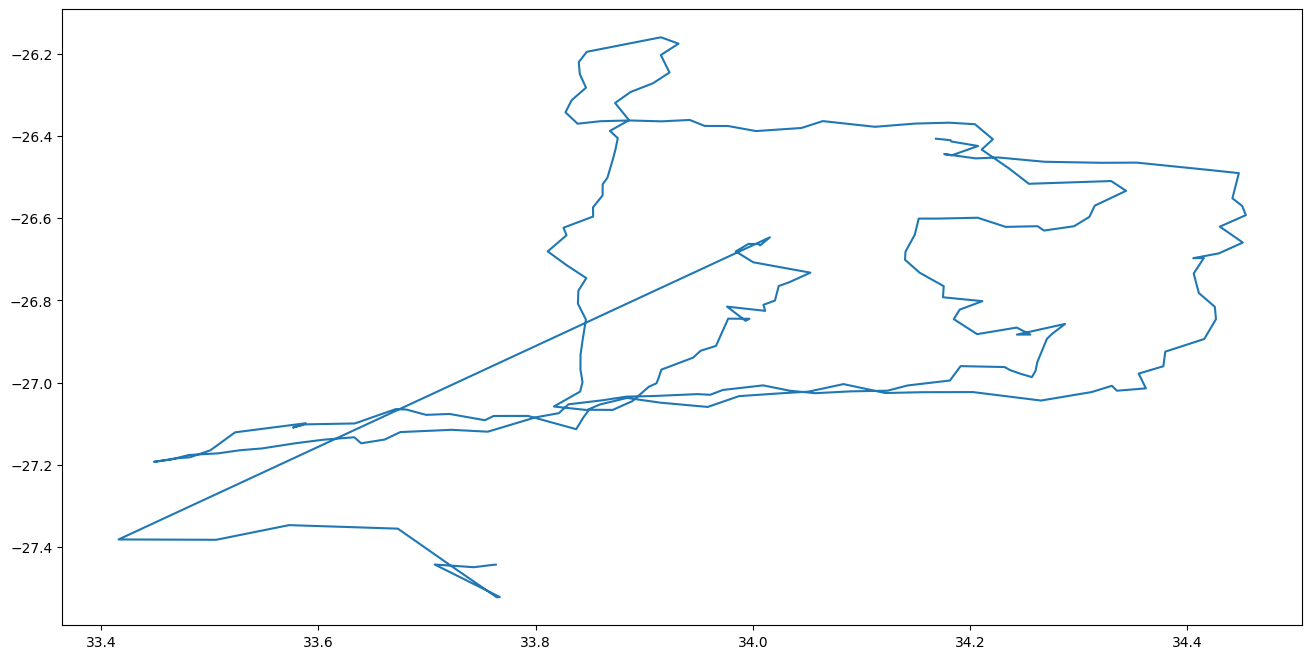

In [75]:
plt.plot(pf_online[:, 0], pf_online[:, 1])

(1600.0, 100.0)

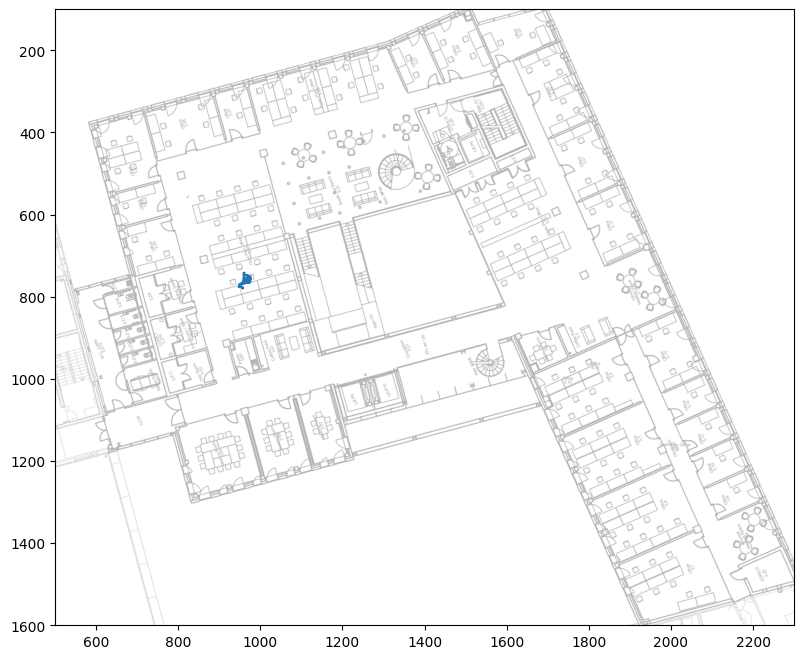

In [76]:
plt.imshow(img, alpha=0.3)
plt.plot(pf_online[:, 0]*meter2pix, -pf_online[:, 1]*meter2pix)
plt.xlim(500, 2300)
plt.ylim(1600, 100)

(1600.0, 100.0)

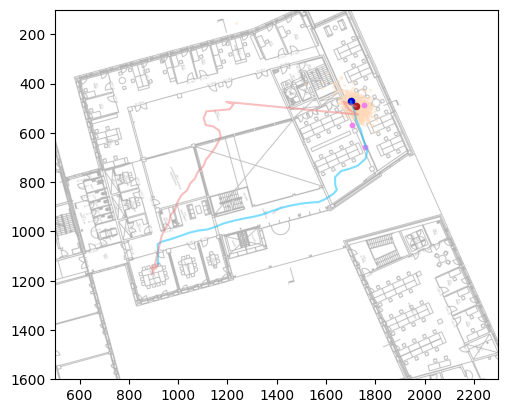

In [24]:
fig_idx = 50
plt.imshow(img, alpha=0.3)
plt.scatter(pf_cloud[fig_idx, :, 0]*meter2pix, -pf_cloud[fig_idx, :, 1]*meter2pix, alpha=0.3, c='peachpuff', s=2)
plt.plot(pf_gt[:fig_idx+1, 0]*meter2pix, -pf_gt[:fig_idx+1, 1]*meter2pix, c='deepskyblue', alpha=0.5)
plt.scatter(pf_gt[fig_idx, 0]*meter2pix, -pf_gt[fig_idx, 1]*meter2pix, c='mediumblue', s=20)
plt.plot(pf_online[:fig_idx+1, 0]*meter2pix, -pf_online[:fig_idx+1, 1]*meter2pix, c='lightcoral', alpha=0.5)
plt.scatter(pf_online[fig_idx, 0]*meter2pix, -pf_online[fig_idx, 1]*meter2pix, c='firebrick', s=20)
plt.scatter(wifi_online[fig_idx, :3, 0]*meter2pix, -wifi_online[fig_idx, :3, 1]*meter2pix, c='violet', s=10)
plt.xlim(500, 2300)
plt.ylim(1600, 100)
plt.xlim(500, 2300)
plt.ylim(1600, 100)

In [112]:
pf_error.max()

23.012901048583203

In [77]:
for fig_idx in tqdm(range(pf_online.shape[0]-1)):
    plt.rcParams["figure.figsize"] = (16,8)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(img, alpha=0.3)
    plt.scatter(pf_cloud[fig_idx, :, 0]*meter2pix, -pf_cloud[fig_idx, :, 1]*meter2pix, alpha=0.3, c='peachpuff', s=2, label='particles')
    plt.plot(pf_gt[:fig_idx+1, 0]*meter2pix, -pf_gt[:fig_idx+1, 1]*meter2pix, c='deepskyblue', alpha=0.5, label='GT history')
    plt.scatter(pf_gt[fig_idx, 0]*meter2pix, -pf_gt[fig_idx, 1]*meter2pix, c='mediumblue', s=20, label='GT now')
    plt.plot(pf_online[:fig_idx+1, 0]*meter2pix, -pf_online[:fig_idx+1, 1]*meter2pix, c='lightcoral', alpha=0.5, label='online history')
    plt.scatter(pf_online[fig_idx, 0]*meter2pix, -pf_online[fig_idx, 1]*meter2pix, c='firebrick', s=20, label='online now')
    plt.scatter(wifi_online[fig_idx, :10, 0]*meter2pix, -wifi_online[fig_idx, :10, 1]*meter2pix, c='violet', s=10, label='wifi pos')
    plt.xlim(600, 2250)
    plt.ylim(1650, 0)
    plt.legend(loc='lower left')
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(fig_idx+1), pf_error[:fig_idx+1])
    plt.xlim(0, pf_online.shape[0])
    plt.ylim(0, pf_error.max() * 1.1)
    ratio = pf_online.shape[0]/(pf_error.max() * 1.1)
    ax.set_aspect(ratio)

    fig.savefig('./viz_15_t10/'+f'{fig_idx:03}'+'.png')
    plt.clf()
    plt.close()

100%|██████████████████████████████████████████████████████████████████| 262/262 [01:23<00:00,  3.14it/s]


In [78]:
meter2pix

28.346472

In [79]:
1/28.35

0.03527336860670194